# Word embeddings

## 0. Données de travail

Nous allons travailler sur les neuf romans de Victor Hugo :
  * Bug-Jargal
  * Claude Gueux
  * Le Dernier Jour d'un condamné
  * Han d'Islande
  * L'Homme qui rit
  * Les Misérables
  * Les Travailleurs de la mer
  * Notre-Dame de Paris
  * Quatrevingt-treize
  
Ils sont disponibles dans le répertoire `data`. Les fichiers présentés sont les sorties de l'analyseur Talisman, ils sont au format conll. Un mot par ligne, les phrases sont séparées par une ligne vide.

Dans ce notebook nous allons utiliser un bon nombre de packages Python différents qui font partie de la boîte à outils NLP : sklearn, pandas, gensim et spacy.

## 1. Vectorisation de documents

Avant d'aborder les *word embeddings* nous allons voir quelques exemples de vectorisations de documents.  
La vectorisation a d'abord été utilisée en recherche d'information pour représenter des documents. Voir Salton, G. (1971). The SMART Retrieval System: Experiments in Automatic Document Processing. Prentice Hall.



In [17]:
from collections import Counter
from os import path
import glob
import pandas as pd

### Représentation des documents sous forme de vecteurs.

Dans un premier temps nous allons compter les occurrences de chaque mot des textes de notre corpus de travail.

In [18]:
def count_words(filepath):
    """
    Compte la fréquence de chaque mot du texte donné en argument
    texte au format conll
    """
    words_freq = Counter()
    with open(filepath) as doc:
        for line in doc:
            cols = line.split("\t")
            if len(cols) > 4:
                form = cols[1]
                lemma = cols[2]
                pos = cols[3]
                if pos != "PONCT":
                    words_freq[form] += 1
    return words_freq

In [19]:
counts = dict() # dictionnaire doc: counter mots
vocab = set() # vocabulaire du corpus
for doc in glob.glob('./data/*.conll'):
    doc_name = path.splitext(path.basename(doc))[0]
    counts[doc_name] = count_words(doc)
    vocab = vocab.union(set(counts[doc_name]))
print("Nombre de types de chaque roman du corpus :")
total_words = 0
for doc in counts:
    print(f"{doc} : {len(counts[doc])}")
    total_words += sum(counts[doc].values())
print(f"\nTaille du vocabulaire du corpus : {len(vocab)}")
print(f"Nombre de mots du corpus : {total_words}")

Nombre de types de chaque roman du corpus :
lhomme_qui_rit : 21460
claude_gueux : 2265
notre-dame_de_paris : 17752
les_miserables : 31959
le_dernier_jour_dun_condamne : 6247
quatrevingt-treize : 13854
han_dislande : 11928
les_travailleurs_de_la_mer : 16623
bug_jargal : 8395

Taille du vocabulaire du corpus : 54596
Nombre de mots du corpus : 1447427


  * Vecteurs de booléens
  
Construction d'une matrice booléenne document-terme (les documents en ligne et les mots en colonnes). On parle aussi de *one hot encoding*.  
Nous aurons une matrice de dimension nb de documents * taille du vocabulaire.

(L'objet DataFrame est uniquement utilisé pour l'affichage commode en tableau, un peu overkill je veux bien l'entendre.)

In [20]:
counts_bool = dict()
for doc in counts:
    counts_bool[doc] = [int(w in counts[doc]) for w in vocab]

df = pd.DataFrame(counts_bool, index=vocab)
df.T

,coalisés,orne,passementé,mascaret,cueillirent,taise,Baucis,regrettais,Révérend,fortifiée,...,recruté,vitesses,zélé,Dételez,Surge,léviathans,température,malingre,Pontorson,symboles
lhomme_qui_rit,0,0,1,0,0,1,1,0,1,0,...,0,1,0,0,1,1,1,0,0,0
claude_gueux,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
notre-dame_de_paris,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,1
les_miserables,0,1,0,0,1,0,1,1,0,0,...,1,0,0,1,0,0,1,1,0,1
le_dernier_jour_dun_condamne,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
quatrevingt-treize,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
han_dislande,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
les_travailleurs_de_la_mer,1,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
bug_jargal,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


  * Vecteurs avec occurrences

La même matrice mais avec le nombre d'occurrences des lemmes. Comme vous le constatez ces matrices contiennent beaucoup de valeurs nulles, un bon nombre des termes du vocabulaire peut être absent d'un document. On parle alors de matrice creuse ou *sparse matrix*.

Les matrices creuses en informatique peuvent être implémentées plus efficacement dans des structures de données dédiées. On trouve des classes de type Sparse Matrix dans le package SciPy.

In [21]:
counts_occ = dict()
for doc in counts:
    counts_occ[doc] = [counts[doc][w] if w in counts[doc] else 0 for w in vocab]

df = pd.DataFrame(counts_occ, index=vocab)
df.T

,coalisés,orne,passementé,mascaret,cueillirent,taise,Baucis,regrettais,Révérend,fortifiée,...,recruté,vitesses,zélé,Dételez,Surge,léviathans,température,malingre,Pontorson,symboles
lhomme_qui_rit,0,0,1,0,0,1,1,0,1,0,...,0,1,0,0,1,1,3,0,0,0
claude_gueux,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
notre-dame_de_paris,0,0,0,0,0,0,0,0,3,1,...,0,0,0,0,0,0,2,0,0,4
les_miserables,0,1,0,0,1,0,1,1,0,0,...,2,0,0,1,0,0,3,3,0,2
le_dernier_jour_dun_condamne,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
quatrevingt-treize,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,0
han_dislande,0,1,0,0,0,0,0,0,2,0,...,0,0,2,0,0,0,0,0,0,0
les_travailleurs_de_la_mer,1,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
bug_jargal,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


  * Vecteurs tf-idf
  
Vous avez vu cette notion en cours. tf-idf associe à chaque terme d'un document un poids qui dépend de la fréquence du terme et du nombre de documents dans lequel le terme apparaît.
  
Pour se faciliter la vie nous allons utiliser la classe ```sklearn.feature_extraction.text.TfidfVectorizer```
Cette classe utilise des *sparse matrix* SciPy différentes des matrices calculées préalablement.

Nous allons repartir des contenus des fichiers.

In [6]:
def get_words(filepath):
    """
    Retourne les mots d'un fichier conll sous forme de liste
    """
    words = []
    with open(filepath) as doc:
        for line in doc:
            cols = line.split("\t")
            if len(cols) > 4:
                form = cols[1]
                lemma = cols[2]
                pos = cols[3]
                if pos != "PONCT":
                    words.append(cols[1])
    return words

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer=lambda x: x) #on neutralise l'analyseur parce que les textes sont déjà tokenizés
corpus = [get_words(doc) for doc in glob.glob('./data/*.conll')]
tfidf_vectors= tfidf.fit_transform(corpus)

On a donc une matrice de 9 x 54596 (la taille de notre vocabulaire)

In [8]:
tfidf_vectors.get_shape()

(9, 54596)

In [22]:
pd.DataFrame(tfidf_vectors.todense(), columns=tfidf.vocabulary_)

,Préface,De,l',Angleterre,tout,est,grand,même,ce,qui,...,courusse,franchîmes,Poursuis,pardonnerai,annonçai,tiendraient,Grand-Diable,compatriotes,accouriez,guérîtes
0,0.000000,0.012991,0.002224,0.003218,0.000501,0.000117,0.010299,0.001294,0.001638,0.000410,...,0.000129,0.000000,0.000000,0.000088,0.000000,0.000198,0.000215,0.000000,0.000000,0.000000
1,0.000000,0.012245,0.002721,0.001361,0.001664,0.001361,0.006803,0.000000,0.002721,0.012245,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001664,0.000000,0.000000,0.000000
2,0.000000,0.011575,0.001596,0.007450,0.000325,0.000599,0.013836,0.001324,0.002727,0.000599,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000113,0.000244,0.000000,0.000000,0.000174
3,0.000117,0.014009,0.001953,0.003862,0.000494,0.000741,0.014189,0.001142,0.001100,0.000584,...,0.000049,0.000117,0.000000,0.000034,0.000000,0.000038,0.000275,0.000117,0.000049,0.000000
4,0.000000,0.017070,0.000356,0.001778,0.000435,0.000356,0.010313,0.004717,0.019559,0.001422,...,0.000000,0.000000,0.000000,0.000537,0.000000,0.000000,0.002175,0.000000,0.000784,0.000000
5,0.000000,0.013734,0.002121,0.002828,0.000371,0.005049,0.011109,0.001340,0.002020,0.000404,...,0.000000,0.000000,0.000264,0.000153,0.000264,0.000171,0.000371,0.000000,0.000000,0.000000
6,0.000000,0.011076,0.005034,0.004632,0.000246,0.000604,0.024870,0.002226,0.004632,0.000201,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.004828,0.002253,0.001448,0.000000,0.000161,0.005713,0.001601,0.000161,0.000322,...,0.000000,0.000000,0.000000,0.000122,0.000000,0.000000,0.000394,0.000000,0.000000,0.000000
8,0.000000,0.009321,0.001591,0.002501,0.000000,0.000455,0.025461,0.001005,0.020687,0.000455,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Les vecteurs tf-idf sont en général utilisés dans des tâches de classification de documents. Plus largement en recherche d'information.  

Mais en soit ils ne sont pas forcément évidents à utiliser. On peut tout de même essayer de donner un exemple en cherchant les valeurs tf-idf se rapportant au terme "mer" dans chacun des 9 romans de notre corpus.

In [31]:
# il faut d'abord trouver l'index du terme recherché dans le vocabulaire
index = tfidf.vocabulary_['mer']
# puis on va afficher les valeurs pour cet index
# ici on manipule des 'sparse matrix', il faut donc les convertir en matrices denses. Ce sont alors des matrices numpy
tfidf_vectors.todense()[:, index]

matrix([[0.01474763],
        [0.        ],
        [0.00117646],
        [0.00119118],
        [0.00039309],
        [0.01149764],
        [0.00178072],
        [0.0369975 ],
        [0.00150772]])

In [32]:
# pour s'y retrouver il faut retrouver l'ordre des romans
[doc for doc in glob.glob('./data/*.conll')]

['./data/lhomme_qui_rit.conll',
 './data/claude_gueux.conll',
 './data/notre-dame_de_paris.conll',
 './data/les_miserables.conll',
 './data/le_dernier_jour_dun_condamne.conll',
 './data/quatrevingt-treize.conll',
 './data/han_dislande.conll',
 './data/les_travailleurs_de_la_mer.conll',
 './data/bug_jargal.conll']

Sans surprise le meilleur score pour le terme 'mer' est attaché au roman Les travailleurs de la mer

Ce type de vectorisation de documents permet d'obtenir des résultats intéressants en recherche d'information mais présente deux défauts :
  * le traitement de type "sac de mots" ne conserve pas l'ordre des mots et leur contexte d'apparition
  * les vecteurs en question sont de grande taille, celle du vocabulaire du corpus. Quitte à être remplis de valeurs nulles.

## 2. Vecteurs de co-occurrences

Si on veut conserver l'information liée au contexte d'apparition des mots d'un corpus il est possible de calculer des vecteurs de co-occurrences en comptant le nombre d'occurrences d'un mot pour chacun de ses n voisins.  
Établir une matrice de co-occurrence pour un corpus d'un vocabulaire de 54596 mots comme le nôtre est difficilement réalisable, ça donnerait une matrice de dimension 54596 x 54596.

## 3. Words embeddings avec Word2vec

En 2013, Mikolov et ses co-auteurs ont proposé avec Word2Vec une méthode pour vectoriser les mots en prenant en compte leur contexte d'apparition dans des vecteurs de dimensions réduites.

La grande nouveauté de Word2Vec est d'utiliser des prédictions plutôt que des comptages.  
Pour la méthode Skip-gram, plutôt que compter combien de fois un mot w apparaît à côté de *abricot*, on va entraîner un classifieur pour la question « est-ce que w a des chances d'apparaître dans le contexte de *abricot* ? ». Les poids du classifieur seront utilisés dans le vecteur du mot *abricot*.  
L'idée est d'utiliser les contextes d'un mot comme un gold pour la question du dessus.

## 3.1 Utiliser un modèle existant

Vous trouverez différents modèles word2vec pré-entraînés sur la page de Jean-Philippe Fauconnier : [https://fauconnier.github.io/#data](https://fauconnier.github.io/#data)  

Nous travaillerons avec un modèle entraîné sur les lemmes du corpus [frWac](http://wacky.sslmit.unibo.it/doku.php?id=corpora) (1.6 milliards de mots) que vous pouvez télécharger en suivant [ce lien](https://s3.us-east-2.amazonaws.com/embeddings.net/embeddings/frWac_non_lem_no_postag_no_phrase_500_skip_cut100.bin) (229 Mb).

In [33]:
from gensim.models import KeyedVectors

model_frwac = KeyedVectors.load_word2vec_format('frWac_no_postag_no_phrase_500_skip_cut100.bin', binary=True)

La fonction phare de la classe ``Word2Vec`` est ``most_similar``. La fonction prend en argument une liste de mots et renvoie les mots les plus similaires accompagnés du score de similarité.

In [34]:
model_frwac.most_similar(['peintre', 'pierre'])

[('sculpteur', 0.6955772638320923),
 ('peindre', 0.5922635793685913),
 ('sculpture', 0.582395076751709),
 ('peinture', 0.5706517696380615),
 ('alechinsky', 0.5598146915435791),
 ('ornemaniste', 0.5505461096763611),
 ('mosaïste', 0.5475016236305237),
 ('artiste', 0.5447638034820557),
 ('aquarelliste', 0.5427569150924683),
 ('maître-verrier', 0.5395710468292236)]

L'exemple de calcul algébrique de Mikolov pour le français donnera :

In [35]:
model_frwac.most_similar(positive = ['roi', 'femme'], negative = ['homme'])

[('reine', 0.5184199810028076),
 ('trôner', 0.4784804582595825),
 ('fille', 0.4731692373752594),
 ('épouse', 0.46881601214408875),
 ('isabeau', 0.4556961953639984),
 ('mari', 0.45401278138160706),
 ('rois', 0.44624990224838257),
 ('reine-mère', 0.44137877225875854),
 ('frédégonde', 0.43637052178382874),
 ('épouser', 0.43594837188720703)]

In [38]:
model_frwac.most_similar(positive = ['paris', 'allemagne'], negative = ['france'])

[('berlin', 0.5503262877464294),
 ('düsseldorf', 0.5331753492355347),
 ('wiesbaden', 0.510122537612915),
 ('francfort', 0.50525963306427),
 ('dresde', 0.5047190189361572),
 ('munich', 0.4912762939929962),
 ('allemand', 0.4876036047935486),
 ('rfa', 0.48687827587127686),
 ('berlin-ouest', 0.4846338927745819),
 ('fribourg-en-brisgau', 0.483795702457428)]

## 3.2 Entraîner un modèle

Nous allons utiliser le module gensim pour entraîner un modèle word2vec sur notre corpus de romans de Victor Hugo.   

Notre unité de traitement pour les données d'entrée ce sera la phrase. Nous allons convertir notre corpus en une liste de phrases. 
Le gros intérêt de word2vec et des words embeddings en général est de pouvoir partir de données brutes, non étiquetées. Néanmoins le travail de préparation du corpus a une grande importance dans le résultat final : tokenisation, normalisation de la casse et éventuellement traitement des mot composés.

In [41]:
sentences = []
sentence = []
for doc in glob.glob('./data/*.conll'):
     with(open(doc, 'r')) as f:
        for line in f:
            line = line.rstrip()
            if line == "":
                if len(sentence) > 0:
                    sentences.append(sentence)
                    sentence = []
            else:
                cols = line.split("\t")
                if len(cols) > 4:
                    form = cols[1]
                    lemma = cols[2]
                    pos = cols[3]
                    if pos != "PONCT":
                        sentence.append(form.lower())

Dans la cellule qui suit nous allons entraîner un modèle word2vec avec notre corpus organisé en phrases.

Le constructeur de la classe Word2Vec peut être appelé avec beaucoup de paramètres : voir la doc [ici](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec)  
Nous allons utiliser les hyper-paramètres suivants :
  * `size` : la dimension des vecteurs (défaut: 100)
  * `window` : la taille en mots de la fenêtre du contexte
  * `sg` : l'algo utilisé (1 pour skip-gram, 0 pour cbow)
  * `iter` : nombre d'itérations sur le corpus

`workers` est le nombre de cœurs logiques que vous allouez au calcul. Attention à ne pas utiliser un nombre de cœurs trop grand.

In [42]:
from gensim.models import Word2Vec

model_hugo = Word2Vec(sentences, size=200, window=5, iter=10, sg=1, workers=4)

In [120]:
# un modèle peut être sauvegardé dans un fichier
model_hugo.save('model_hugo_200_window5_sg.model')

# et inversement chargé depuis un fichier
#model_hugo = Word2Vec.load('model_hugo_200_window5_sg.model'')

/usr/local/share/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


La fonction phare de la classe ``Word2Vec`` est ``most_similar``. La fonction prend en argument une liste de mots et renvoie les mots les plus similaires accompagnés du score de similarité.

In [47]:
model_hugo.wv.most_similar(['céleste'])

[('indéfinissable', 0.7904361486434937),
 ('inexprimable', 0.7759684324264526),
 ('indicible', 0.7747398614883423),
 ('angélique', 0.7719113826751709),
 ('inconscient', 0.7675231099128723),
 ('ineffable', 0.7653089761734009),
 ('ravissement', 0.7634984254837036),
 ('poignant', 0.7597588300704956),
 ('mélange', 0.7570196390151978),
 ('spectrale', 0.755940854549408)]

In [19]:
model_hugo.wv.most_similar(['palais', 'paris'])

[('louvre', 0.6941391825675964),
 ('épiscopal', 0.6428191661834717),
 ('notre-dame', 0.6370177268981934),
 ('moyen-âge', 0.6364502906799316),
 ('charles_v', 0.6355208158493042),
 ('saint-germain', 0.6297650337219238),
 ('bicêtre', 0.6296465992927551),
 ('saint-pierre', 0.6270199418067932),
 ('abbaye', 0.6183359622955322),
 ('cathédrale', 0.6167324781417847)]

In [49]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from sklearn.decomposition import PCA

def display_words_vectors_pca(model, words):
    word_vectors = np.array([model[w] for w in words])
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(7,7))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

<ipython-input-49-d9e28ce819f2>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  word_vectors = np.array([model[w] for w in words])


<IPython.core.display.Javascript object>


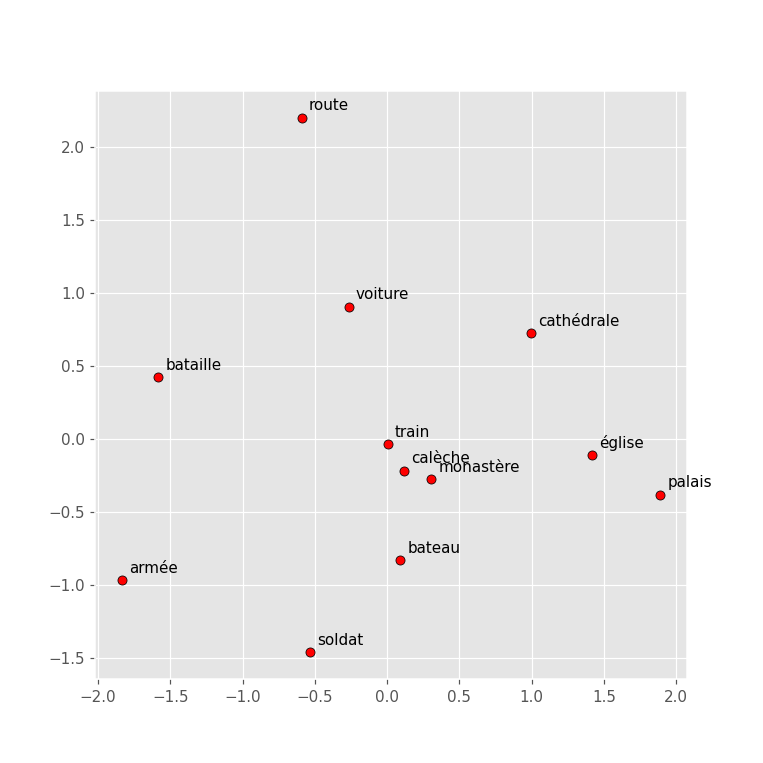

In [50]:
words = ['palais', 'église', 'cathédrale', 'monastère', 'route', 'train', 'bateau', 'calèche', 'voiture', 'armée', 'soldat', 'bataille']
display_words_vectors_pca(model_hugo, words)

Sans surprise un modèle appris sur des données plus volumineuses donne de meilleurs résultats.

<IPython.core.display.Javascript object>


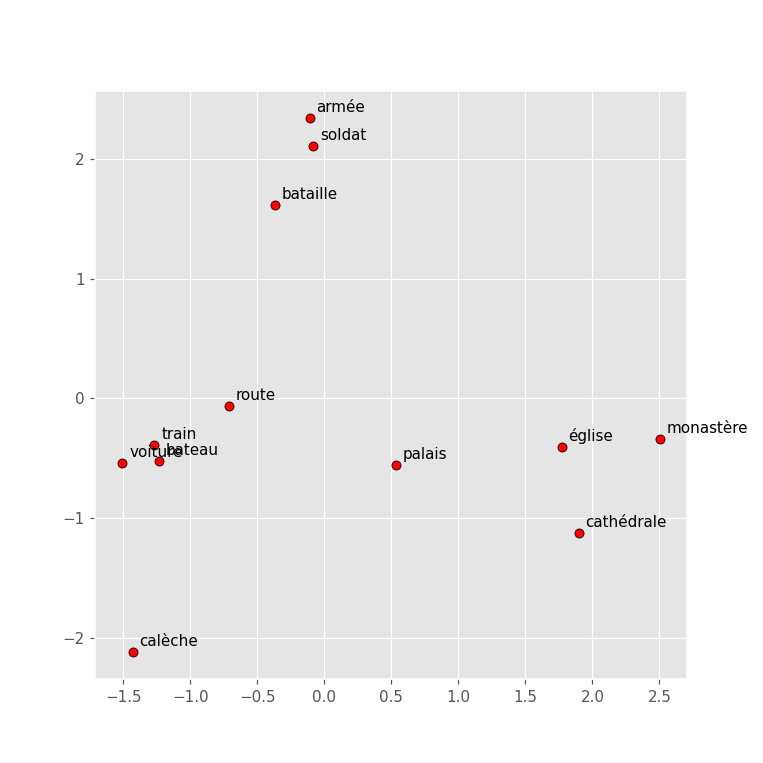

In [51]:
words = ['palais', 'église', 'cathédrale', 'monastère', 'route', 'train', 'bateau', 'calèche', 'voiture', 'armée', 'soldat', 'bataille']
display_words_vectors_pca(model_frwac, words)

In [53]:
model_hugo.most_similar(positive = ['général', 'église'], negative = ['armée'])

<ipython-input-53-1bca489ffd71>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model_hugo.most_similar(positive = ['général', 'église'], negative = ['armée'])


[('curé', 0.5687136650085449),
 ('saint-jacques-du-haut-pas', 0.5385929346084595),
 ('griffenfeld', 0.5248559713363647),
 ('prédicateur', 0.5237425565719604),
 ('prévôt', 0.5214896202087402),
 ('bailli', 0.5186296701431274),
 ('mestienne', 0.5141832828521729),
 ('monseigneur', 0.5061153173446655),
 ('bienfaisant', 0.5047922730445862),
 ('testament', 0.497602641582489)]